# Clustering caveolin from the all-atoms simulation

Simulation: Caveolin in a POPC bilayer (628 ns).

Similarity pattern: RMSD distance metric.

Cluster analysis with a hierarchecal method: Ward's minimum variance method.

In [137]:
from __future__ import print_function, division
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy

In [3]:
directory = '/home/chevrot/Simulations/Caveolin/All_atoms/MD_abacus_weria/2/'
xtc_file = directory+'protein_fit.xtc'
pdb_file = directory+'protein.pdb'

In [5]:
traj = md.load(xtc_file, top=pdb_file)

Discard the first 100ns

In [18]:
traj = traj[500:]

Pairwise RMSDs between conformations

In [71]:
atom_indices = [a.index for a in traj.topology.atoms if a.element.symbol != 'H']
distances = np.empty((traj.n_frames, traj.n_frames))
for i in range(traj.n_frames):
    #distances[i] = md.rmsd(traj, traj, i)
    distances[i] = md.rmsd(traj, traj, i, atom_indices=atom_indices)
print('Max pairwise rmsd: %f nm' % np.max(distances))

Max pairwise rmsd: 1.044394 nm


Clustering with the Ward's algorithm

In [72]:
linkage = scipy.cluster.hierarchy.ward(distances)

Plotting the dendrogram

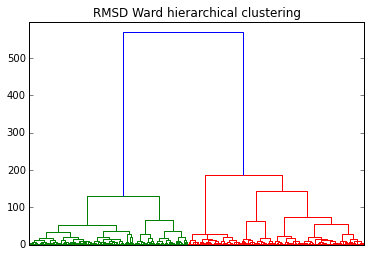

In [73]:
plt.title('RMSD Ward hierarchical clustering')
scipy.cluster.hierarchy.dendrogram(linkage, no_labels=True, count_sort='descendent')
None

In [74]:
dendrogram = scipy.cluster.hierarchy.dendrogram(linkage, no_labels=True, count_sort='descendent', no_plot=True)

Let's choose only 2 clusters

In [85]:
threshold = 300   # chosen from the dendrogram plot
clusters = scipy.cluster.hierarchy.fcluster(linkage, threshold, 'distance')
n_cluster1 = len(clusters[clusters==1])
n_cluster2 = len(clusters[clusters==2])

In [86]:
frames_cluster1 = (dendrogram['ivl'][:n_cluster1])
frames_cluster2 = (dendrogram['ivl'][n_cluster1:])

## Finding centroids

Finding a "centroid" (representitive structure) for the 2 clusters

In [96]:
frames_cluster1 = [int(i) for i in frames_cluster1]
frames_cluster2 = [int(i) for i in frames_cluster2]
cluster1 = traj[frames_cluster1]
cluster2 = traj[frames_cluster2]

Calculating the pairwise RMSDs between the conformations for each cluster

In [100]:
dist = []
for cluster in (cluster1, cluster2):
    atom_indices = [a.index for a in cluster.topology.atoms if a.element.symbol != 'H']
    distances = np.empty((cluster.n_frames, cluster.n_frames))
    for i in range(cluster.n_frames):
        distances[i] = md.rmsd(cluster, cluster, i, atom_indices=atom_indices)
    dist.append(distances)

Transforming these distances into similarity scores. The similarities can be calculated as

$$s_{ij}=e^{−β⋅d_{ij}}/d_{scale}$$

where $s_{ij}$ is the pairwise similarity, $d_{ij}$ is the pairwise distance, and $d_{scale}$ is the standard deviation of the values of d.
Then, the centroid is defined as

$$argmax_i \sum_j s_{ij}$$

In [120]:
beta = 1
index_clusters = []
for i in range(len(dist)):
    index = np.exp(-beta*dist[i] / dist[i].std()).sum(axis=1).argmax()
    index_clusters.append(index)

In [135]:
for index in index_clusters:
    print(index)

148
952


In [183]:
centroids = []
clusters = (cluster1, cluster2)
for index, cluster in zip(index_clusters, clusters):
    centroids.append(cluster[index])

In [195]:
centroids

[<mdtraj.Trajectory with 1 frames, 925 atoms, 55 residues, and unitcells at 0x7fa79c8ec1d0>,
 <mdtraj.Trajectory with 1 frames, 925 atoms, 55 residues, and unitcells at 0x7fa71da42850>]

In [197]:
centroids[0].save_pdb('centroid_1.pdb')
centroids[1].save_pdb('centroid_2.pdb')